In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndimage

In [2]:
# Set up grid. dx=dy=2 km, dA=4 km2
# Will be harder for lat/lon grid, with different staggering of u,v...
x = np.linspace(0, 198, 100)
y = np.linspace(0, 198, 100)
xmin, xmax = x[[0, -1]]
ymin, ymax = y[[0, -1]]
X, Y = np.meshgrid(x, y)

dx = x[1] - x[0]
dy = y[1] - y[0]
dA = dx * dy
print(dx, dy, dA)

2.0 2.0 4.0


## Generate cloud field and label contiguous clouds

In [3]:
# Build brightness temp field, Tb.
Tb = np.ones((100, 100)) * 300  # initialize Tb to 300 K.

def add_cloud(X, Y, Tb, max_size=100, max_strength=100):
    loc = (np.random.random() * xmax, np.random.random() * ymax)
    size = 40 + np.random.random() * max_size
    strength = 30 + np.random.random() * max_strength
    cloud = -strength * np.exp(-(((X - loc[0])**2 / (2 * size)) + (Y - loc[1])**2 / (2 * size)))
    Tb += cloud

# Add 10 'clouds'. Note, some may overlap, and some might not meet threshold criterion,
# so there will be 10 or fewer detected clouds.
ncloud = 10
for i in range(ncloud):
    add_cloud(X, Y, Tb)


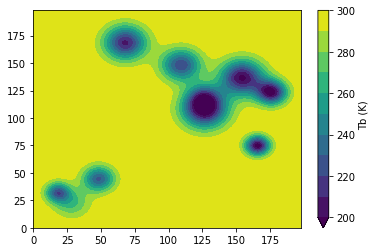

In [4]:
# Display Tb.
fig, ax = plt.subplots(1, 1)
im = ax.contourf(x, y, Tb, levels=np.linspace(200, 300, 11), extend='min')
plt.colorbar(im, ax=ax, label='Tb (K)')


In [5]:
# Define clouds based on Tb threshold.
Tb_thresh = 240  # K
cloud_mask = Tb < Tb_thresh  # here, mask is defined so that 1s represent cloud

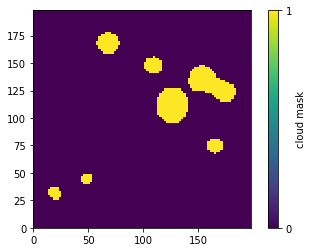

In [6]:
# Display cloudy areas (1s). Note, masks are on grid, and imshow shows this nicely.
fig, ax = plt.subplots(1, 1)
im = ax.imshow(cloud_mask, origin='lower', extent=(xmin, xmax, ymin, ymax), interpolation='nearest')
plt.colorbar(im, ax=ax, label='cloud mask', ticks=[0, 1])


In [7]:
# Let's have a look at ndimage.label documentation.
ndimage.label?

Signature: ndimage.label(input, structure=None, output=None)
Docstring:
Label features in an array.

Parameters
----------
input : array_like
    An array-like object to be labeled. Any non-zero values in `input` are
    counted as features and zero values are considered the background.
structure : array_like, optional
    A structuring element that defines feature connections.
    `structure` must be centrosymmetric
    (see Notes).
    If no structuring element is provided,
    one is automatically generated with a squared connectivity equal to
    one.  That is, for a 2-D `input` array, the default structuring element
    is::

        [[0,1,0],
         [1,1,1],
         [0,1,0]]

output : (None, data-type, array_like), optional
    If `output` is a data type, it specifies the type of the resulting
    labeled feature array.
    If `output` is an array-like object, then `output` will be updated
    with the labeled features from this function.  This function can
    operate in-plac

In [7]:
# Label contiguous objects.
cloud_labels, nlabels = ndimage.label(cloud_mask)

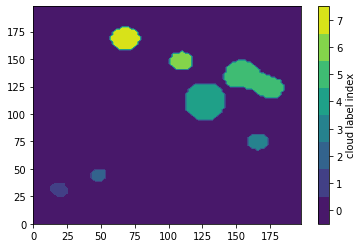

In [8]:
# Display labels. 
# env is cloud_labels == 0.
fig, ax = plt.subplots(1, 1)
im = ax.contourf(X, Y, cloud_labels, levels=np.arange(nlabels + 2) - 0.5)
plt.colorbar(im, ax=ax, label='cloud label index', ticks=range(nlabels + 1))

Text(0, 0.5, 'Y (km)')

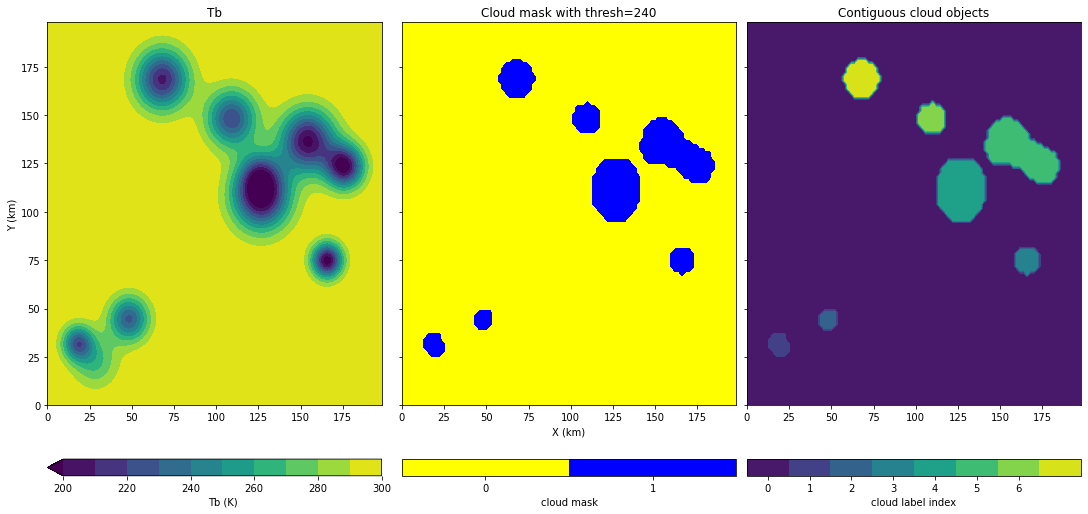

In [9]:
# Display all fields so far. Note cloud mask and cloud objects are shown using contours,
# which slightly distorts their outlines compared to imshow.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True, layout='constrained')
fig.set_size_inches(15, 7)

ax1.set_title('Tb')
im = ax1.contourf(x, y, Tb, levels=np.linspace(200, 300, 11), extend='min')
plt.colorbar(im, ax=ax1, label='Tb (K)', orientation='horizontal')

ax2.set_title(f'Cloud mask with thresh={Tb_thresh}')
im = ax2.contourf(x, y, cloud_mask, levels=[-0.5, 0.5, 1.5], colors=['yellow', 'blue', 'blue'])
plt.colorbar(im, ax=ax2, label='cloud mask', ticks=[0, 1], orientation='horizontal')

ax3.set_title(f'Contiguous cloud objects')
im = ax3.contourf(X, Y, cloud_labels, levels=np.arange(nlabels + 2) - 0.5)
plt.colorbar(im, ax=ax3, label='cloud label index', ticks=range(nlabels), orientation='horizontal')

ax2.set_xlabel('X (km)')
ax1.set_ylabel('Y (km)')

In [10]:
# For each labelled/detected cloud (id=1, 2, 3, ncloud), save some details (area, centroid).
detected_clouds = []
for i in range(1, nlabels + 1):
    # This will be slightly harder on a lat/lon grid!
    # Might be OK to assume equal area grid cells.
    area = (cloud_labels == i).sum() * dA
    
    yidx, xidx = np.where(cloud_labels == i)
    xs = x[xidx]
    ys = y[yidx]
    centroid = (xs.mean(), ys.mean())
    mcs_area_thresh = 400  # km2 (not realistic for an MCS!)
    cloud = {
        'cloud_id': i,
        'area': area,
        'centroid': centroid,
        'is_mcs': area > mcs_area_thresh,
    }
    detected_clouds.append(cloud)
print(detected_clouds)

[{'cloud_id': 1, 'area': 116.0, 'centroid': (19.103448275862068, 31.17241379310345), 'is_mcs': False}, {'cloud_id': 2, 'area': 88.0, 'centroid': (48.18181818181818, 44.18181818181818), 'is_mcs': False}, {'cloud_id': 3, 'area': 156.0, 'centroid': (166.0, 74.82051282051282), 'is_mcs': False}, {'cloud_id': 4, 'area': 756.0, 'centroid': (126.93121693121694, 111.44973544973546), 'is_mcs': True}, {'cloud_id': 5, 'area': 848.0, 'centroid': (162.16981132075472, 131.35849056603774), 'is_mcs': True}, {'cloud_id': 6, 'area': 200.0, 'centroid': (109.4, 148.28), 'is_mcs': False}, {'cloud_id': 7, 'area': 320.0, 'centroid': (68.0, 168.775), 'is_mcs': False}]


## Use detected clouds to find environment within each cloud

In [11]:
# Create a random field. We'll use this to act as an "environmental" variable:
env_var_binary = (np.random.random((100, 100)) > 0.98).astype(float)  # binary field.
env_var_smooth = ndimage.gaussian_filter(env_var_binary, sigma=10)  # apply smoothing.
env_var = env_var_smooth / env_var_smooth.max() * 30  # scale so max value = 30.

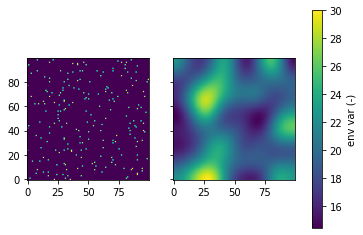

In [12]:
# Display env_var.
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
ax1.imshow(env_var_binary, origin='lower')
im = ax2.imshow(env_var, origin='lower')
plt.colorbar(im, ax=(ax1, ax2), label='env var (-)')

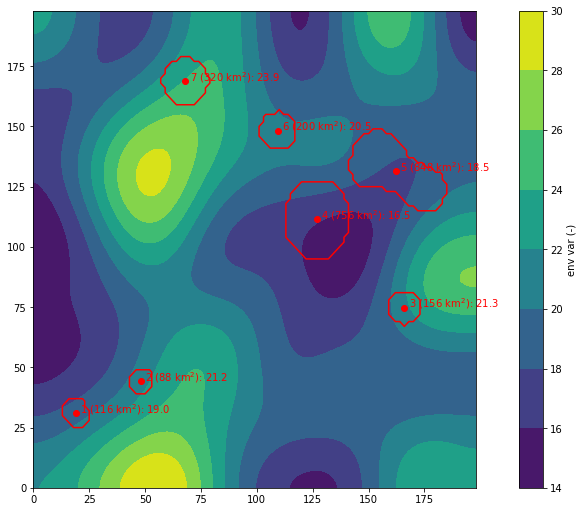

In [13]:
# demonstrate how to extract environment for a given cloud mask:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, layout='constrained')
fig.set_size_inches(8, 7)
im = ax.contourf(x, y, env_var)
ax.contour(x, y, cloud_labels >= 1, levels=[0.5], colors=['red'])
plt.colorbar(im, ax=ax, label='env var (-)')

for cloud in detected_clouds:
    cloud_x, cloud_y = cloud['centroid']
    cloud_id = cloud['cloud_id']
    # cloud_labels == cloud_id masks out area that is true for given cloud.
    # Using this to index into env_var just selects env_var for that cloud.
    mean_val_in_cloud = env_var[cloud_labels == cloud_id].mean()
    area = cloud['area']
    
    ax.plot(cloud_x, cloud_y, 'o', c='red')
    cloud_text = f'{cloud_id} ({area:.0f} km$^2$): {mean_val_in_cloud:.1f}'
    ax.text(cloud_x + 2, cloud_y, cloud_text, color='red')